# <span style="background: linear-gradient(135deg,#fce38a,#f38181); -webkit-background-clip: text; color: transparent;font-weight: bold; font-style: italic; font-size: 32pt;">Ordinary Differential Equations Tests</span>

## <span style="background: linear-gradient(135deg,#f54ea2,#ff7676); -webkit-background-clip: text; color: transparent;font-weight: bold; font-style: italic; font-size: 24pt;">Harmonic Oscillator  Equation</span>

Given the deterministic conditions:

$$
\frac{\partial^2 u}{\partial x^2} + u = 0\\
u(0) = 0, u(1) = 1
$$

### Data Generation

Get the `X_input` points by sampling randomly on the computational domain. The computational domain is defined by the interval $[0, 1]$ for the variable $x$. The `y_input` is defined as the value of source term $f(x)$ at the corresponding `X_input` point(i.e. equal to 0) and the boundary condition $u(0) = 0$ or $u(1) = 0$. 

Note that in this process, we do not need to know the exact solution of the equation. The `Ground Truth` is used to evaluate the performance of the model.

In [1]:
import numpy as np
import sympy as sp


def calculate_source(solution):
    ''' Calculate the source term of the PDE '''
    # solution: sympy expr of the solution
    real_params = dict()
    for symbol in sp.preorder_traversal(solution):
        if isinstance(symbol, sp.Symbol):
            exec('%s = sp.Symbol("%s")' % (symbol.name, symbol.name))
            if symbol.name not in real_params:
                real_params[symbol.name] = None
    real_params = sorted(list(real_params.keys()))
    print(f'real_params:{real_params}')
    source = 0
    for i in real_params:
        source += sp.diff(solution, i, 2)
    source = source + solution
    print(f'source:{source}')
    solution_func = sp.lambdify(real_params, solution, modules='numpy')
    if source == 0:
        source_func = lambda *args: np.zeros_like(args[0])
    else:
        source_func = sp.lambdify(real_params, source, modules='numpy')
    return solution_func, source_func, real_params

# Validating the solution and the source term
GROUND_TRUTH = sp.sympify('sin(x)/sin(1)')
solution_func, source_func, real_params = calculate_source(GROUND_TRUTH)


real_params:['x']
source:0


In [2]:
np.random.seed(100)
LEFT_BC, RIGHT_BC = 0, 1
N_SAMPLES = 20 # collect n_samples points in the domain
N_BOUNDARY = 20 # collect n_boundary points on the boundary

n_vars = len(real_params)
X = np.random.uniform(LEFT_BC, RIGHT_BC, (N_SAMPLES, n_vars))
X_bc = np.array([[LEFT_BC],[RIGHT_BC]])
assert X_bc.shape == (2, n_vars)
X_combine = np.concatenate([X, X_bc], axis=0)
assert X_combine.shape == (N_SAMPLES+2, n_vars)
y = source_func(*X_combine.T).reshape(-1, 1)
y_bc = solution_func(*X_bc.T).reshape(-1, 1)

X_input = [X, X_bc]
y_input = [y, y_bc] # bc points are computed twice in y and y_bc

test_X = np.random.uniform(LEFT_BC, RIGHT_BC, (N_SAMPLES, n_vars))
test_y = solution_func(*test_X.T).reshape(-1, 1)

### Reinforcement Learning 

We use single RL method to solve the ODE with closed form solution. Here we define the equation in the `pde.py` file. and use the configuration file `config_haros` to define the hyperparameters of the model.

In [3]:
import logging
import time
from ssde import PDESymbolicSolver

# configure logging
logging.basicConfig(filename='haros.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# redirect output to logger
class RedirectOutput:
    def __init__(self, logger):
        self.logger = logger

    def write(self, message):
        if message.strip() != "":
            self.logger.info(message)

    def flush(self):
        pass

import sys
sys.stdout = RedirectOutput(logger)
sys.stderr = RedirectOutput(logger)

model = PDESymbolicSolver("./config/config_haros.json")
start_time = time.time()
model.fit(X_input, y_input) # Should solve in ~10 hours
print(model.program_.pretty())
print('Using time(s):', time.time()-start_time)


/home/weishu/.conda/envs/ssde/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <span style="background: linear-gradient(135deg,#f54ea2,#ff7676); -webkit-background-clip: text; color: transparent;font-weight: bold; font-style: italic; font-size: 24pt;">Van der Por Equation</span>

Given the deterministic conditions:

$$  
\frac{\partial^2 u}{\partial x^2} - (1-u^2) \frac{\partial u}{\partial x} + u = 0\\
u(0) = 0, u(1) = 1
$$

### Numerical solution & Data Generation

We use the `PINN` method to visualize the solution on the points sampled from the computational domain randomly. 

Note that we do not use the numerical solution as the reward function of reinforcement learning here. The exact computation process of the numerical solution can be found in the [`numerical_solver.ipynb`](./numerical/numerical_solver.ipynb) file.

/home/weishu/.conda/envs/ssde/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


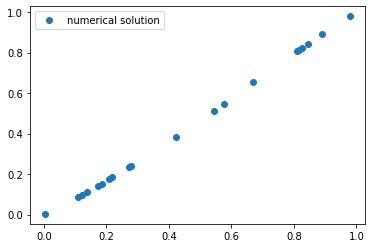

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from vanderpol_num import PINNSolver, FDMSolver

np.random.seed(100)
MU = 1
LEFT_BC, RIGHT_BC = 0, 1
N_SAMPLES = 20 # collect n_samples points in the domain
N_BOUNDARY = 20 # collect n_boundary points on the boundary

X = np.random.uniform(LEFT_BC, RIGHT_BC, (N_SAMPLES, 1))
X_bc = np.array([[LEFT_BC],[RIGHT_BC]])
assert X_bc.shape == (2, 1)
X_combine = np.concatenate([X, X_bc], axis=0)
assert X_combine.shape == (N_SAMPLES+2, 1)
y_bc = np.array([[0],[1]])
y = np.zeros_like(X_combine)
X_input = [X, X_bc]
y_input = [y, y_bc] # bc points are computed twice in y and y_bc


num_model = PINNSolver()
numerical_sol = num_model(torch.tensor(X, dtype=torch.float32)).cpu().detach().numpy()
plt.plot(X, numerical_sol, 'o', label='numerical solution')
plt.legend()
plt.show()

### Reinforcement Learning

We use single RL method to solve the ODE with a non-linear term that causes it doesn't have a closed form solution. Here we define the equation in the `pde.py` file. and use the configuration file `config_haros` to define the hyperparameters of the model.

In [2]:
import logging
import time
from ssde import PDESymbolicSolver

# configure logging
logging.basicConfig(filename='./varderpol.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# redirect output to logger
class RedirectOutput:
    def __init__(self, logger):
        self.logger = logger

    def write(self, message):
        if message.strip() != "":
            self.logger.info(message)

    def flush(self):
        pass

import sys
sys.stdout = RedirectOutput(logger)
sys.stderr = RedirectOutput(logger)

model = PDESymbolicSolver("./config/config_vanderpol.json")
start_time = time.time()
model.fit(X_input, y_input) # Should solve in ~10 hours
print(model.program_.pretty())
print(model.program_.sympy_expr)
print('Using time(s):', time.time()-start_time)

### Evaluation

We use `SymPy` to get the symbol residual of the identified closed-form solution.  Then evaluate the closed-form solution on the grid points sampled from the computational domain with numerical solution got from the `FD` method.

In [1]:
import sympy as sp
def calculate_source(solution):
    ''' Calculate the source term of the PDE '''
    # solution: sympy expr of the solution
    real_params = dict()
    for symbol in sp.preorder_traversal(solution):
        if isinstance(symbol, sp.Symbol):
            exec('%s = sp.Symbol("%s")' % (symbol.name, symbol.name))
            if symbol.name not in real_params:
                real_params[symbol.name] = None
    real_params = sorted(list(real_params.keys()))
    print(f'real_params:{real_params}')
    source = sp.diff(solution, real_params[0], 2) + solution -  (1-solution**2) * sp.diff(solution, real_params[0])
    print(f'source:{source}')
    solution_func = sp.lambdify(real_params, solution, modules='numpy')
    if source == 0:
        source_func = lambda *args: np.zeros_like(args[0])
    else:
        source_func = sp.lambdify(real_params, source, modules='numpy')
    return solution_func, source_func, real_params

# identified solution
# cfs = model.program_.sympy_expr
cfs =  sp.sympify("(0.70954114*x1 + 0.70954114*sin(x1))/(2.2949312 - cos(x1 - 1.1396402))")
cfs = sp.sympify("x1")

# calculate the source term
solution_func, source_func, real_params = calculate_source(cfs)

real_params:['x1']
source:-(1 - 0.0955907396852859*(x1 + sin(x1))**2/(1 - 0.435742910288552*cos(x1 - 1.1396402))**2)*((0.70954114*cos(x1) + 0.70954114)/(2.2949312 - cos(x1 - 1.1396402)) - 0.189871883866737*(0.70954114*x1 + 0.70954114*sin(x1))*sin(x1 - 1.1396402)/(1 - 0.435742910288552*cos(x1 - 1.1396402))**2) - 0.70954114*(x1 + sin(x1))*(0.189871883866737*cos(x1 - 1.1396402) + 0.165470654516124*sin(x1 - 1.1396402)**2/(0.435742910288552*cos(x1 - 1.1396402) - 1))/(0.435742910288552*cos(x1 - 1.1396402) - 1)**2 - 0.269443825865505*(cos(x1) + 1)*sin(x1 - 1.1396402)/(0.435742910288552*cos(x1 - 1.1396402) - 1)**2 + 0.70954114*sin(x1)/(cos(x1 - 1.1396402) - 2.2949312) + (0.70954114*x1 + 0.70954114*sin(x1))/(2.2949312 - cos(x1 - 1.1396402))


We set the numerical solution got from the `FD` method as the `Ground Truth` whose source residual is `2.18e-13`. And test the cfs found by `DESIRE` on the same grid points. The source residual of the cfs is `1.16e-05`. Compared with the `Ground Truth`, the mse of solution found by `DESIRE` method is `2.59e-5`, while the mse of the PINN method is `2.87e-05`.

In [10]:
import numpy as np
from vanderpol_num import PINNSolver, FDMSolver
import torch
X_test = np.linspace(0, 1, 100).reshape(-1, 1)
y_pred = solution_func(*X_test.T).reshape(-1, 1)
num_model = PINNSolver()
y_pinn = num_model(torch.tensor(X_test, dtype=torch.float32)).cpu().detach().numpy()
solver = FDMSolver(n_points=101, mu=1)
y_fdm, r = solver.solve(max_iter=1000)
y_fdm = y_fdm[1:].reshape(-1, 1)
print('MSE of PDE (FDM):', r)
# source residual
pred_source = source_func(*X_test.T).reshape(-1, 1)
print('MSE of PDE (DESIRE):', np.mean(pred_source**2))
pde_loss = np.mean(pred_source**2)
X_bc = np.array([[0],[1]])
bc_s = solution_func(*X_bc.T).reshape(-1,1)
y_bc = np.array([[0],[1]])
bc_loss = np.mean((y_bc-bc_s)**2)
L_phy = np.mean(np.sqrt(bc_loss) + np.sqrt(pde_loss))
print(f'L_phy:{L_phy}')

Newton iterations:   1%|          | 11/1000 [00:00<00:03, 307.19it/s]

Converged after 12 iterations
MSE of PDE (FDM): 2.1881887069119893e-13
MSE of PDE (DESIRE): 5.090678214188506e-05
L_phy:0.008183290711262128


In [ ]:
print('MSE of Solution (DESIRE):', np.mean((y_pred - y_fdm)**2))
print('MSE of Solution (PINN):', np.mean((y_pinn - y_fdm)**2))
plt.plot(X_test, y_pred, "o", label='identified solution')
plt.plot(X_test, y_pinn,"o", label='PINN')
plt.plot(X_test, y_fdm,"o", label='FDM(Ground Truth)')
plt.legend()
plt.show()